In [1]:
!git clone https://github.com/SKTBrain/KoBERT.git
!cd KoBERT
!pip install -r requirements.txt
!pip install .

Cloning into 'KoBERT'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 231 (delta 33), reused 29 (delta 12), pack-reused 155
Receiving objects: 100% (231/231), 199.27 KiB | 2.73 MiB/s, done.
Resolving deltas: 100% (115/115), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9 MB 71 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 4.3 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595742 sha256=2a5c38dff63054d3ce7b4b6dd80efe5921dc74993c52f518d9067343855fbdd1
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 68.3 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 3.3 MB 84.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstal

In [3]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-aryefgnc
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-aryefgnc
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12770 sha256=1dec8143ea2b69f419c36f020565f2e108dd762dcb633bc8e69a82917d1fdcdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-mz2dvfj5/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [4]:
import re
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [5]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [6]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score,f1_score

In [8]:
##GPU 사용 시
device = torch.device("cuda:0")

In [9]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [10]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
path = "gdrive/MyDrive/Colab Notebooks/[Dacon]_Climate_Technology_Classification/open/"
train=pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')
sample_submission=pd.read_csv(path+'/sample_submission.csv')

In [12]:
train.columns

Index(['index', '제출년도', '사업명', '사업_부처명', '계속과제여부', '내역사업명', '과제명', '요약문_연구목표',
       '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드', 'label'],
      dtype='object')

In [13]:
test.columns

Index(['index', '제출년도', '사업명', '사업_부처명', '계속과제여부', '내역사업명', '과제명', '요약문_연구목표',
       '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드'],
      dtype='object')

In [14]:
def text_preprocessing(sent):
  for i in range(len(sent)):
    sent[i][0] = re.sub("[^가-힣ㄱ-하-ㅣa-zA-Z]", " ", sent[i][0])
  return sent

In [15]:
train=train[['과제명', '요약문_연구목표', '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드','label']]
test=test[['과제명', '요약문_연구목표', '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드']]

train['요약문_연구목표'].fillna('NAN', inplace=True)
train['요약문_연구내용'].fillna('NAN', inplace=True)
train['요약문_기대효과'].fillna('NAN', inplace=True)
train['요약문_한글키워드'].fillna('NAN', inplace=True)
train['요약문_영문키워드'].fillna('NAN', inplace=True)

test['요약문_연구목표'].fillna('NAN', inplace=True)
test['요약문_연구내용'].fillna('NAN', inplace=True)
test['요약문_기대효과'].fillna('NAN', inplace=True)
test['요약문_한글키워드'].fillna('NAN', inplace=True)
test['요약문_영문키워드'].fillna('NAN', inplace=True)

train['data']=train['과제명']+train['요약문_연구목표']+train['요약문_연구내용']+train['요약문_기대효과']+train['요약문_한글키워드']+train['요약문_영문키워드']
test['data']=test['과제명']+test['요약문_연구목표']+test['요약문_연구내용']+test['요약문_기대효과']+test['요약문_한글키워드']+test['요약문_영문키워드']

train = train[['data','label']]

validation = train[:len(train)//5]
train = train[len(train)//5:]
test = test[['data']]

In [16]:
import matplotlib.pyplot as plt

데이터 길이 최댓값: 10973
데이터 길이 최솟값: 18
데이터 길이 평균값: 1575.4430237227848
데이터 길이 중간값: 1438.0


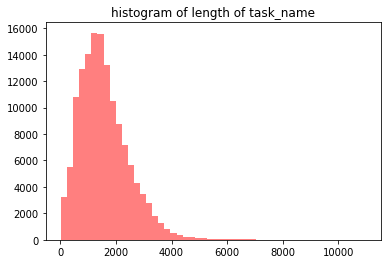

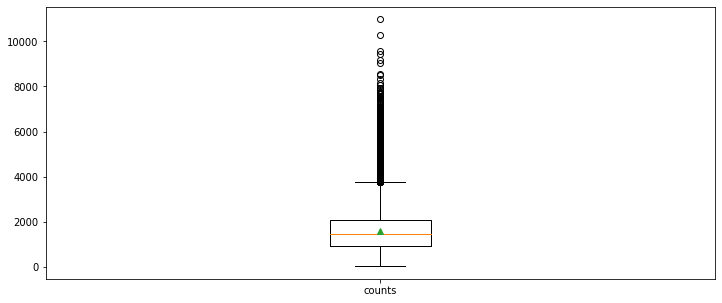

In [17]:
length=train['data'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of task_name')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('데이터 길이 최댓값: {}'.format(np.max(length)))
print('데이터 길이 최솟값: {}'.format(np.min(length)))
print('데이터 길이 평균값: {}'.format(np.mean(length)))
print('데이터 길이 중간값: {}'.format(np.median(length)))

In [18]:
print(train.shape)
print(validation.shape)
print(test.shape)

(139444, 2)
(34860, 2)
(43576, 1)


In [19]:
train = train.values
validation = validation.values
test = test.values

In [20]:
train = text_preprocessing(train)
validation = text_preprocessing(validation)
test = text_preprocessing(test)

In [21]:
train.shape

(139444, 2)

In [22]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [23]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, bert_tokenizer, max_len,
                 pad, pair, *label_idx):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        if label_idx:
          self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
      try:
        return (self.sentences[i] + (self.labels[i], ))
      except:
        return (self.sentences[i])

    def __len__(self):
      try:
        return (len(self.labels))
      except:
        return (len(self.sentences))

In [24]:
## Setting parameters
max_len = 256
batch_size = 32
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [25]:
data_train = BERTDataset(train, 0, tok, max_len, True, False, 1)

In [26]:
data_validation = BERTDataset(validation, 0, tok, max_len, True, False, 1)

In [27]:
data_test = BERTDataset(text_preprocessing(test), 0, tok, max_len, True, False)

In [28]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
validation_dataloader = torch.utils.data.DataLoader(data_validation, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [29]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=46,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [30]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [31]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [32]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [33]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [34]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [35]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [36]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        #print( batch_id, (token_ids, valid_length, segment_ids, label))
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(validation_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 3.399165391921997 train acc 0.1875
epoch 1 batch id 201 loss 2.298757314682007 train acc 0.5813121890547264
epoch 1 batch id 401 loss 1.247262716293335 train acc 0.6984881546134664
epoch 1 batch id 601 loss 0.6721099019050598 train acc 0.7367408485856906
epoch 1 batch id 801 loss 1.0167993307113647 train acc 0.7549157303370787
epoch 1 batch id 1001 loss 0.5730175375938416 train acc 0.7683254245754245
epoch 1 batch id 1201 loss 0.5794105529785156 train acc 0.7764883430474604
epoch 1 batch id 1401 loss 0.19244910776615143 train acc 0.7824768022840828
epoch 1 batch id 1601 loss 0.3936977684497833 train acc 0.787535134291068
epoch 1 batch id 1801 loss 0.8706712126731873 train acc 0.7926325652415325
epoch 1 batch id 2001 loss 0.5109273195266724 train acc 0.7973825587206397
epoch 1 batch id 2201 loss 1.1928648948669434 train acc 0.8005736029077692
epoch 1 batch id 2401 loss 0.47033944725990295 train acc 0.8045475843398584
epoch 1 batch id 2601 loss 1.1132673025131226 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RuntimeError: ignored

In [ ]:
torch.save(model.state_dict(), path+'KoBERT_v3.1.pth')
print("model saved")

### **모델 불러와 결과 예측하기**




In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
model.load_state_dict(torch.load(path+'KoBERT_v2.0.pth'))

<All keys matched successfully>

In [ ]:
results = []
for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  _, predicted = torch.max(out, 1)
  for i in range(len(predicted)):
    results.append(torch.IntTensor.item(predicted[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_submission['label']=results

In [ ]:
sample_submission

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0
...,...,...
43571,217875,0
43572,217876,0
43573,217877,2
43574,217878,0


In [ ]:
sample_submission.to_csv(path+'KoBERT10_v2.0_results.csv', index=False)